# <center>Домашнее задание № 4. <br>Нейронные сети<br>Выполнил студент группы ИУК4-11М Чикишев А.Д.
# Простой классификатор изображений

классификатор изображений, созданный с помощью PyTorch и CIFAR-10.


Классификатор изображений — это модель машинного обучения, которая распознает объекты на изображениях. Мы можем создавать классификаторы изображений, передавая десятки тысяч помеченных изображений в нейронную сеть. Такие инструменты, как PyTorch, обучают эти сети, оценивая их производительность в сравнении с набором данных.

Далее будет создан классификатор изображений, который обнаруживает самолеты, автомобили, птиц, кошек, оленей, собак, лягушек, лошадей, корабли и грузовики. Необходимо скачать набор данных, настроить нейронную сеть, обучить модель и оценить ее производительность.

## Шаг 1: Загрузка набора данных и просмотр изображений

Модель хороша настолько, насколько хорош ее набор данных.

Учебным инструментам требуется много высококачественных данных для построения точных моделей. Мы будем использовать [набор данных CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) из 60 000 фотографий для создания нашего классификатора изображений. Начать следует с загрузки набора данных с помощью Torchvision и предварительного просмотра нескольких изображений из него.

Files already downloaded and verified
Files already downloaded and verified


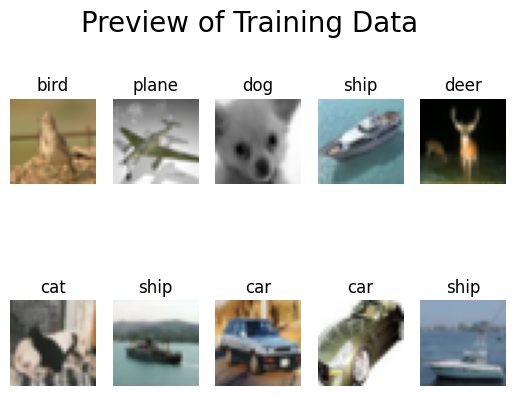

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Загрузка набора данных CIFAR-10 в ./data
batch_size=10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Данная модель распознает такие объекты
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Захват изображений из тренировочных данных
dataiter = iter(trainloader)
images, labels = dataiter.next()

for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1)
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Добавляем метку изображения
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Шаг 2: Настройка нейронной сети

Теперь, когда у нас есть набор данных, нам нужно настроить нейронную сеть для PyTorch. Наша нейронная сеть преобразует изображение в описание.

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Определение сверточной нейронной сети
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Сеть готова к обучению!")

Сеть готова к обучению!


# Шаг 3: Обучение сети и сохранение модели

PyTorch обучает нашу сеть, настраивая ее параметры и оценивая ее производительность по сравнению с нашим помеченным набором данных.

In [18]:
from tqdm import tqdm

EPOCHS = 2
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Сохраняем нашу обученную модель
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 2 of 2: 100%|████████████████████████| 5000/5000 [00:21<00:00, 232.07it/s]


# Шаг 4: Тестирование обученной модели

Давайте протестируем нашу модель!

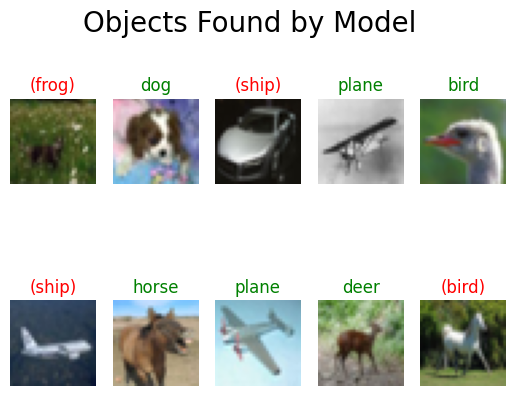

In [19]:
# Выбираем случайные фотографии из тренировочного набора
if dataiter == None:
    dataiter = iter(testloader)
images, labels = dataiter.next()

# Загружаем модель
net = Net()
net.load_state_dict(torch.load(PATH))

# Анализ изображения
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Показать результаты
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1)
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Шаг 5: Оценика точности модели

В заключение оценим общую производительность нашей модели.

In [20]:
# Измерение точности для каждого класса
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Распечатать статистику точности
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 43.2 %
Accuracy for class: car   is 69.8 %
Accuracy for class: bird  is 40.3 %
Accuracy for class: cat   is 31.8 %
Accuracy for class: deer  is 38.8 %
Accuracy for class: dog   is 42.2 %
Accuracy for class: frog  is 73.1 %
Accuracy for class: horse is 57.6 %
Accuracy for class: ship  is 78.0 %
Accuracy for class: truck is 56.9 %


**Вывод:** в ходе выполнения работы были сформированы практические навыки построения, обучения и анализа моделей на базе нейронных сетей. В качестве базы для нейронных сетей был выбран фреймворк PyTorch, поскольку он является распространенным инструментом для изучения данной области. Он не так прост, как интерактивный playground, но и не так сложен и гибок, как tensorflow. В качестве входных параметров для обучения использовались объекты из [набора данных CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), которые состоят из картинок и лейблов, привязанных к ним. В качестве структуры для классификации использовалась сверточная нейронная сеть, а функция потерь представляет собой встроенную crossentropyloss. Это особенно полезно, когда есть несбалансированный тренировочный набор. В результате получилась модель, которая неоднозначно и не очень качественно определяет принадлежность объекта какому-либо из вышеуказанных классов. Однако лягушек, кораблей и лошадей она угадывает в большинстве процентов случаев, а вот кошек и оленей гораздо реже. В данной модели использовалось 6 слоев.